## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
!nvidia-smi

Fri Oct  2 08:02:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Restore model weights

In [ ]:
!wget https://github.com/ariG23498/G-SimCLR/releases/download/v3.0/ImageNet_Subset_Shallow_Autoencoder.zip
!unzip -qq ImageNet_Subset_Shallow_Autoencoder.zip

In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.7MB 5.5MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 163kB 39.6MB/s 
     |████████████████████████████████| 122kB 32.3MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 


In [ ]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# Authorize wandb
import wandb
wandb.login()
from wandb.keras import WandbCallback

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


## Dataset gathering and preparation

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 48.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [ ]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [ ]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

  9%|▉         | 23/250 [00:00<00:00, 227.72it/s]

(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 208.81it/s]


(250, 224, 224, 3) (250,)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('ImageNet_Subset_Shallow_Autoencoder/gsimclr_imagenet_subset_shallow_autoencoder.h5')
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [ ]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [ ]:
# Encoder model with no projection
extractor = Model(resnet_simclr.input, resnet_simclr.layers[-6].output) # weights are already loaded

def get_training_model(trainable=False):
    inputs = Input(shape=(224, 224, 3))
    extractor.trainable = trainable
    x = extractor(inputs, training=False)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

In [ ]:
model = get_training_model()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_3 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


## Warmup

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/35
2/2 [==============================] - 3s 2s/step - loss: 2.2629 - accuracy: 0.2320 - val_loss: 2.1024 - val_accuracy: 0.2760
Epoch 2/35
2/2 [==============================] - 2s 819ms/step - loss: 2.1863 - accuracy: 0.3120 - val_loss: 1.7851 - val_accuracy: 0.3600
Epoch 3/35
2/2 [==============================] - 2s 845ms/step - loss: 1.6758 - accuracy: 0.4320 - val_loss: 1.5800 - val_accuracy: 0.3120
Epoch 4/35
2/2 [==============================] - 1s 461ms/step - loss: 1.5960 - accuracy: 0.3200 - val_loss: 1.9452 - val_accuracy: 0.2120
Epoch 5/35
2/2 [==============================] - 2s 752ms/step - loss: 1.5719 - accuracy: 0.2480 - val_loss: 1.4747 - val_accuracy: 0.3520
Epoch 6/35
2/2 [==============================] - 1s 472ms/step - loss: 1.3963 - accuracy: 0.4560 - val_loss: 1.5011 - val_accuracy: 0.4240
Epoch 7/35
2/2 [==============================] - 1s 527ms/step - loss: 1.4673 - accuracy: 0.4640 - val_loss: 1.5505 - val_accuracy: 0.4200
Epoch 00007: early stop

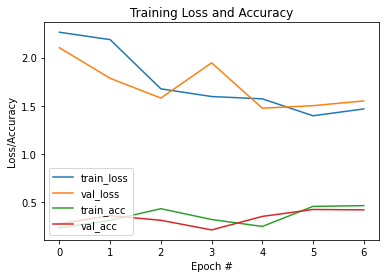

In [ ]:
model = get_training_model()
wandb.init(entity="g-simclr", project="g-simclr", id="imagenet-s-gsimclr-shallow-ae-wup")

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = model.fit(X_train, y_train_enc,
                 validation_data=(X_test, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

## Fine-tune

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,6
loss,1.46726
accuracy,0.464
val_loss,1.5505
val_accuracy,0.42
_step,6
_runtime,24
_timestamp,1601626371
best_val_loss,1.47474
best_epoch,4


epoch,▁▂▃▅▆▇█
loss,█▇▃▃▂▁▂
accuracy,▁▃▇▄▁██
val_loss,█▄▂▆▁▁▂
val_accuracy,▃▆▄▁▆██
_step,▁▂▃▅▆▇█
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█


Epoch 1/35
2/2 [==============================] - 5s 2s/step - loss: 1.3595 - accuracy: 0.4640 - val_loss: 1.4258 - val_accuracy: 0.4160
Epoch 2/35
2/2 [==============================] - 3s 2s/step - loss: 1.1439 - accuracy: 0.5040 - val_loss: 1.4185 - val_accuracy: 0.3680
Epoch 3/35
2/2 [==============================] - 20s 10s/step - loss: 1.0133 - accuracy: 0.6000 - val_loss: 1.3509 - val_accuracy: 0.4800
Epoch 4/35
2/2 [==============================] - 15s 7s/step - loss: 0.9124 - accuracy: 0.6720 - val_loss: 1.3504 - val_accuracy: 0.4720
Epoch 5/35
2/2 [==============================] - 15s 8s/step - loss: 0.8294 - accuracy: 0.7280 - val_loss: 1.3431 - val_accuracy: 0.4680
Epoch 6/35
2/2 [==============================] - 11s 5s/step - loss: 0.7477 - accuracy: 0.8080 - val_loss: 1.3309 - val_accuracy: 0.4480
Epoch 7/35
2/2 [==============================] - 1s 676ms/step - loss: 0.6866 - accuracy: 0.8240 - val_loss: 1.3454 - val_accuracy: 0.4680
Epoch 8/35
2/2 [=================

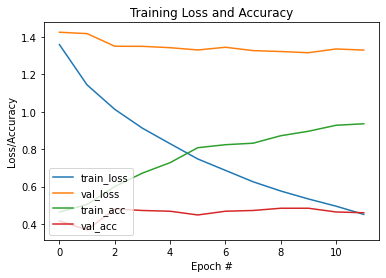

In [ ]:
model.layers[1].trainable = True
wandb.init(entity="g-simclr", project="g-simclr", id="imagenet-s-gsimclr-shallow-ae-ft")

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer=tf.keras.optimizers.Adam(1e-5)) # Low learning rate

history = model.fit(X_train, y_train_enc,
                 validation_data=(X_test, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)